In [1]:
!pip install python==3.8
import rasterio
!pip install keplergl
import keplergl
import base64
import IPython
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install reverse_geocoder
import reverse_geocoder as rg
!pip install scikit-learn==1.1.3

ERROR: Could not find a version that satisfies the requirement python==3.8 (from versions: none)
ERROR: No matching distribution found for python==3.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 53.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for keplergl: filename=keplergl-0.3.2-py2.py3-none-any.whl size=17922320 sha256=7827aa0193933da135975e634c9eb6c0af6220d3528deb486dd1f3a0c8ddbf37
  Stored in directory: /root/.cache/pip/wheels/1f/30/1d/c13f5030f6e73cecb8d7bb3210ee28fce4f25717ddfcb03ed2
Successfully built keplergl


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=d23bcf46c395de6d4d972cd46be80a30e5ca47a8a00243b2541535deda4dccc2
  Stored in directory: /root/.cache/pip/wheels/66/c0/4f/7cf67939fe7d9ad1b414081f6057aa7d57cc6d6bec16ed0f9a
Successfully built reverse_geocoder
ERROR: Ignored the following versions that require a different python version: 1.1.0 Requires-Python >=3.8; 1.1.1 Requires-Python >=3.8; 1.1.2 Requires-Python >=3.8; 1.1.3 Requires-Python >=3.8; 1.2.0 Requires-Python >=3.8; 1.2.0rc1 Requires-Python >=3.8; 1.2.1 Requires-Python >=3.8; 1.2.2 Requires-Python >=3.8
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.1.3 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0

In [2]:
train = pd.read_csv('/kaggle/input/bizinnovate-2023/train.csv')
test = pd.read_csv('/kaggle/input/bizinnovate-2023/test_masked.csv')
train.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,urban,path
0,IA-2015-7-00010004,IA,2015,9.165413,92.742696,22.0,2.650768,22.0,5.000000,10004,1,R,dhs_train/IA-2015-7-00010004.npz
1,IA-2015-7-00010005,IA,2015,8.307356,93.093792,22.0,2.157784,22.0,5.000000,10005,1,R,dhs_train/IA-2015-7-00010005.npz
2,IA-2015-7-00010007,IA,2015,7.016968,93.893226,21.0,1.832751,21.0,4.619048,10007,1,R,dhs_train/IA-2015-7-00010007.npz
3,IA-2015-7-00010016,IA,2015,9.194938,92.800432,22.0,2.746096,22.0,5.000000,10016,1,R,dhs_train/IA-2015-7-00010016.npz
4,IA-2015-7-00010018,IA,2015,8.055606,93.543892,22.0,2.581869,22.0,5.000000,10018,1,R,dhs_train/IA-2015-7-00010018.npz


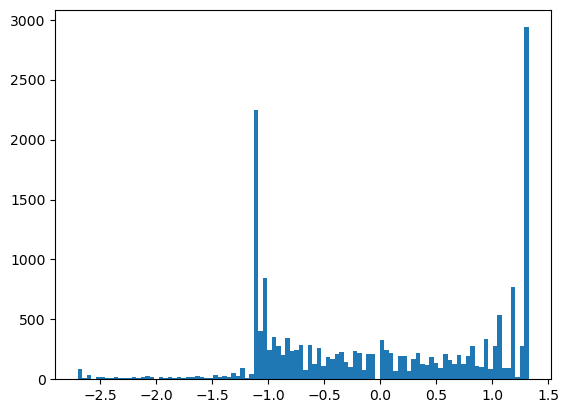

In [48]:
from sklearn.preprocessing import PowerTransformer

boxcoxTr = PowerTransformer(standardize=True)
wi_trans = boxcoxTr.fit_transform(train['water_index'].values.reshape(-1,1))

plt.hist(wi_trans, bins=100)
plt.show()

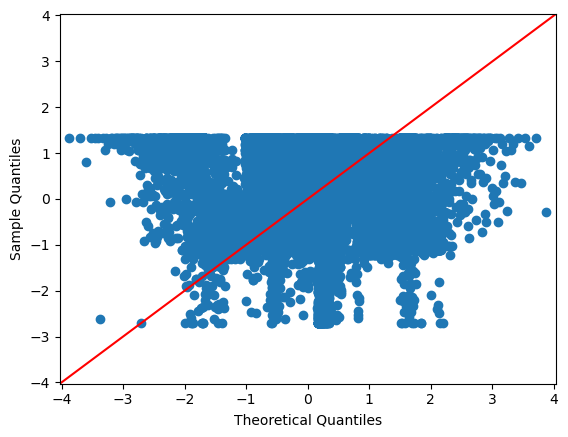

In [49]:
import statsmodels.api as sm

sm.qqplot(wi_trans, line='45')
plt.show()

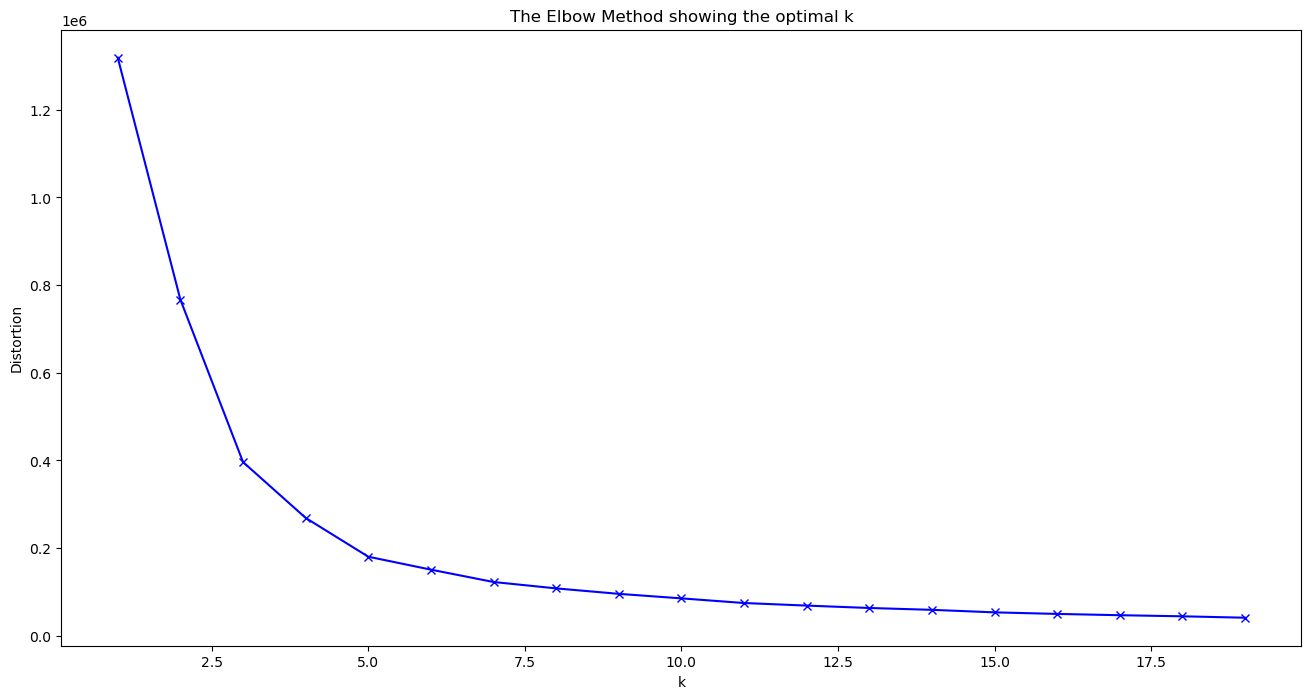

In [5]:
from sklearn.cluster import KMeans

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(train[['lat', 'lon']])
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [3]:
# no areas are overlapping exactly
train_area_match = train[train[['lat', 'lon']].nunique(axis=1) == 1]
train_area_match

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,urban,path


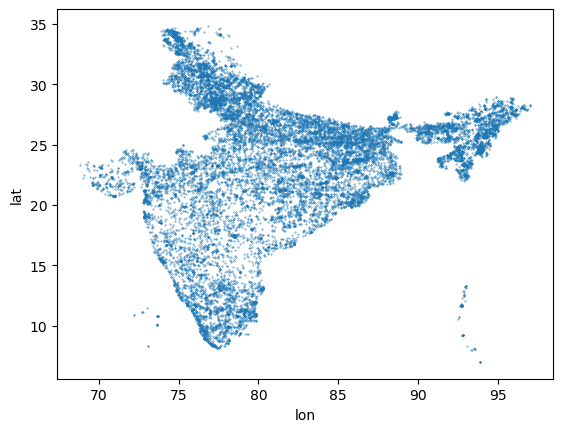

In [15]:
train.plot.scatter(x='lon', y='lat', s=0.1);

In [16]:
train['lon'].diff().mean()

-0.0006826055191282513

In [17]:
train['lat'].diff().mean()

0.0004352287573350775

In [4]:
train_coord = train[['lat', 'lon', 'asset_index']]
train_coord.head()

,lat,lon,asset_index
0,9.165413,92.742696,2.650768
1,8.307356,93.093792,2.157784
2,7.016968,93.893226,1.832751
3,9.194938,92.800432,2.746096
4,8.055606,93.543892,2.581869


In [8]:
train_coord.to_numpy()

array([[ 9.16541348, 92.7426959 ,  2.65076817],
       [ 8.30735626, 93.09379244,  2.15778423],
       [ 7.01696798, 93.89322639,  1.83275082],
       ...,
       [17.93923086, 79.51250898,  1.31536115],
       [17.42017451, 78.49101256,  2.92089326],
       [17.31333105, 79.96363797,  0.98500796]])

In [ ]:
!pip install sklearn --upgrade
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

model = KMeans(n_init='auto', random_state=123)
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(train_coord.to_numpy())  # Fit the data to the visualizer
visualizer.finalize();

In [18]:
train

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,...,urban,path,geometry,x_cart,y_cart,z_cart,rot_45_x,rot_45_y,rot_30_x,rot_30_y
0,IA-2015-7-00010004,IA,2015,9.165413,92.742696,22.0,2.650768,22.0,5.000000,10004,...,R,dhs_train/IA-2015-7-00010004.npz,POINT (92.74270 9.16541),-404.361229,6144.619606,1633.947028,72.049033,72.049033,54.308596,84.897881
1,IA-2015-7-00010005,IA,2015,8.307356,93.093792,22.0,2.157784,22.0,5.000000,10005,...,R,dhs_train/IA-2015-7-00010005.npz,POINT (93.09379 8.30736),-1129.723217,2551.600628,5727.364201,71.690612,71.690612,53.741067,84.772902
2,IA-2015-7-00010007,IA,2015,7.016968,93.893226,21.0,1.832751,21.0,4.619048,10007,...,R,dhs_train/IA-2015-7-00010007.npz,POINT (93.89323 7.01697),4437.115909,-1642.607140,4266.554253,71.343507,71.343507,53.023307,84.820018
3,IA-2015-7-00010016,IA,2015,9.194938,92.800432,22.0,2.746096,22.0,5.000000,10016,...,R,dhs_train/IA-2015-7-00010016.npz,POINT (92.80043 9.19494),-763.863164,6156.251666,1451.454268,72.110726,72.110726,54.363032,84.962643
4,IA-2015-7-00010018,IA,2015,8.055606,93.543892,22.0,2.581869,22.0,5.000000,10018,...,R,dhs_train/IA-2015-7-00010018.npz,POINT (93.54389 8.05561),-972.629933,825.720187,6241.940258,71.830845,71.830845,53.748101,85.036813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18717,IA-2015-7-00360473,IA,2015,17.184983,79.989186,22.0,0.629311,22.0,4.272727,360473,...,R,dhs_train/IA-2015-7-00360473.npz,POINT (79.98919 17.18498),72.262189,592.181911,-6343.007154,68.702138,68.702138,54.876788,77.863127
18718,IA-2015-7-00360475,IA,2015,17.465781,78.418820,20.0,2.704372,20.0,5.000000,360475,...,U,dhs_train/IA-2015-7-00360475.npz,POINT (78.41882 17.46578),-1175.921638,142.980397,-6259.904625,67.790413,67.790413,54.334777,76.643589
18719,IA-2015-7-00360480,IA,2015,17.939231,79.512509,17.0,1.315361,17.0,4.882353,360480,...,R,dhs_train/IA-2015-7-00360480.npz,POINT (79.51251 17.93923),-2200.805889,-3230.035589,-5031.199114,68.898380,68.898380,55.291628,77.827448
18720,IA-2015-7-00360481,IA,2015,17.420175,78.491013,23.0,2.920893,23.0,5.000000,360481,...,U,dhs_train/IA-2015-7-00360481.npz,POINT (78.49101 17.42017),-896.885355,43.806180,-6307.401896,67.809209,67.809209,54.331377,76.683304


In [7]:
train['adm1dhs'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35,
       36])

In [19]:
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

transformer = make_column_transformer(
    (StandardScaler(), ['lat', 'lon', 'asset_index', 'cluster_id']),
    (OneHotEncoder(drop="if_binary"), ['urban', 'adm1dhs']),
    ('drop', ['DHSID_EA', 'cname', 'year', 'n_asset', 'n_water', 'path'])
)

pipe = make_pipeline(transformer, LGBMRegressor())

In [21]:
X_train = train.drop(columns=['water_index'])
y_train = train[['water_index']]

pipe.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['lat', 'lon', 'asset_index',
                                                   'cluster_id']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['urban', 'adm1dhs']),
                                                 ('drop', 'drop',
                                                  ['DHSID_EA', 'cname', 'year',
                                                   'n_asset', 'n_water',
                                                   'path'])])),
                ('lgbmregressor', LGBMRegressor())])

In [24]:
from sklearn.metrics import r2_score

train_preds = pipe.predict(X_train)
r2_score(y_train, train_preds)

0.7806508894447437

In [27]:
test_preds = pipe.predict(test)
new_sub = test.copy()
new_sub['water_index'] = test_preds
new_sub = new_sub[['DHSID_EA', 'water_index']]

In [31]:
new_sub.to_csv('test.csv', index=False)

In [60]:
ohe_feature_names = pipe.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out(['urban', 'adm1dhs']).tolist()
# print(ohe_feature_names)

feature_names = (['lat', 'lon', 'asset_index', 'cluster_id'] + ohe_feature_names)
# print(feature_names)

X_train_enc = pd.DataFrame(
    data=transformer.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index
)
X_train_enc.head()

,lat,lon,asset_index,cluster_id,urban_U,adm1dhs_1,adm1dhs_2,adm1dhs_3,adm1dhs_4,adm1dhs_5,...,adm1dhs_26,adm1dhs_27,adm1dhs_28,adm1dhs_30,adm1dhs_31,adm1dhs_32,adm1dhs_33,adm1dhs_34,adm1dhs_35,adm1dhs_36
0,-2.568589,1.751373,1.325497,-1.832600,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.722339,1.807388,1.028181,-1.832591,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.953555,1.934932,0.832154,-1.832571,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.563299,1.760584,1.382989,-1.832484,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.767448,1.879198,1.283944,-1.832465,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
import shap

lgbm_explainer = shap.TreeExplainer(pipe.named_steps["lgbmregressor"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

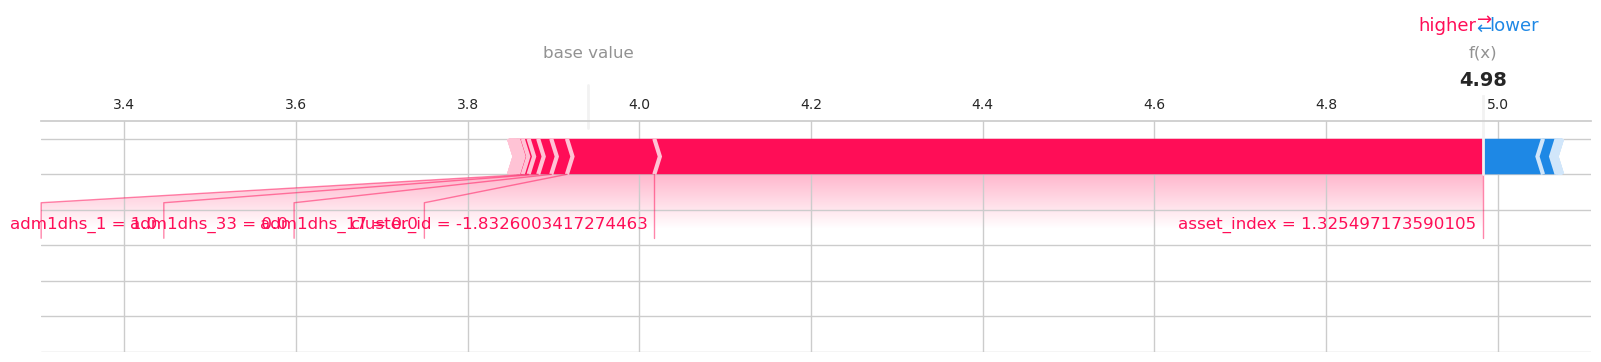

In [64]:
shap.force_plot(
    lgbm_explainer.expected_value,
    train_lgbm_shap_values[0, :], # SHAP values associated with the example we want to explain
    X_train_enc.iloc[0, :], # Feature vector of the example 
    matplotlib=True
)

In [76]:
y_train_5 = y_train[y_train['water_index'] == 5.0].index.tolist()
y_train_1 = y_train[y_train['water_index'] == 1.0].index.tolist()

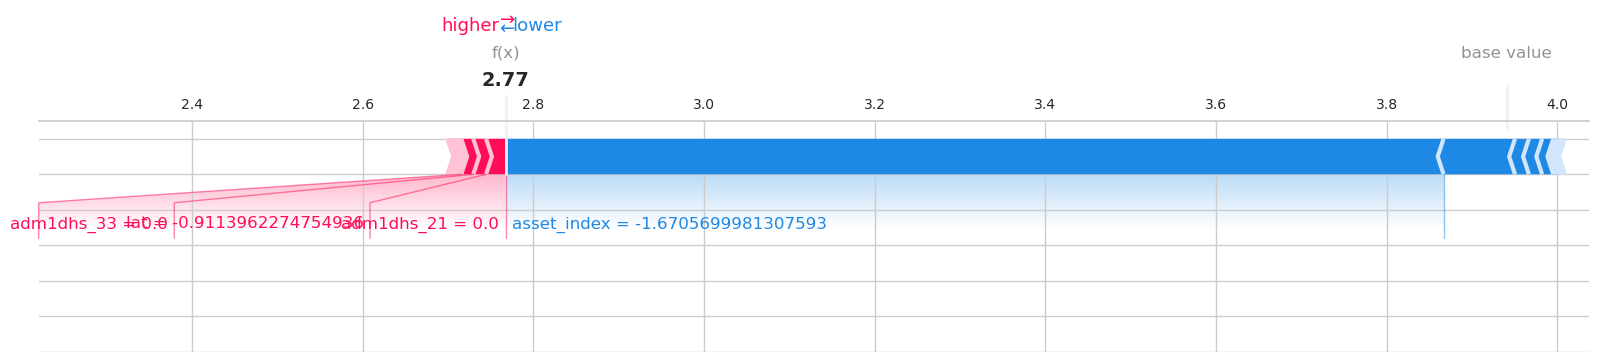

In [79]:
shap.force_plot(
    lgbm_explainer.expected_value,
    train_lgbm_shap_values[y_train_1[0], :], # SHAP values associated with the example we want to explain
    X_train_enc.iloc[y_train_1[0], :], # Feature vector of the example 
    matplotlib=True
)

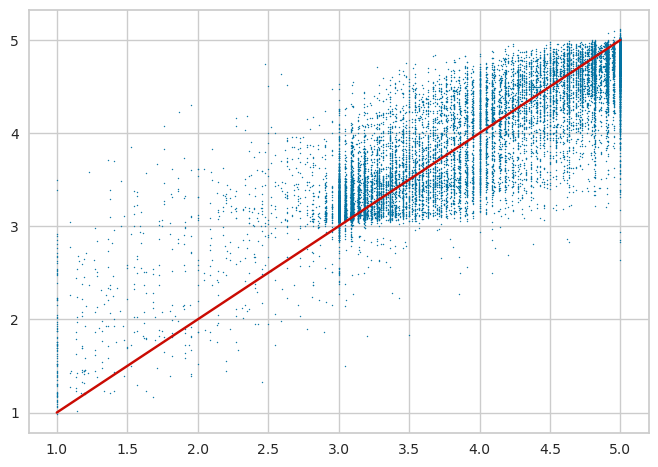

In [90]:
plt.scatter(y_train, train_preds, s=0.5)
plt.plot(np.arange(1,6), np.arange(1,6), c='r');

In [3]:
example = np.load('/kaggle/input/bizinnovate-2023/dhs_train/IA-2015-7-00010004.npz')
example['x'].shape

(8, 255, 255)

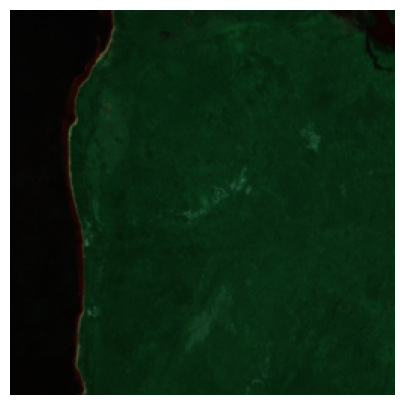

In [15]:
plt.figure(figsize=(5, 5))
plt.imshow(np.moveaxis(example['x'], 0, -1)[:, :, 2:5])
plt.axis("off");

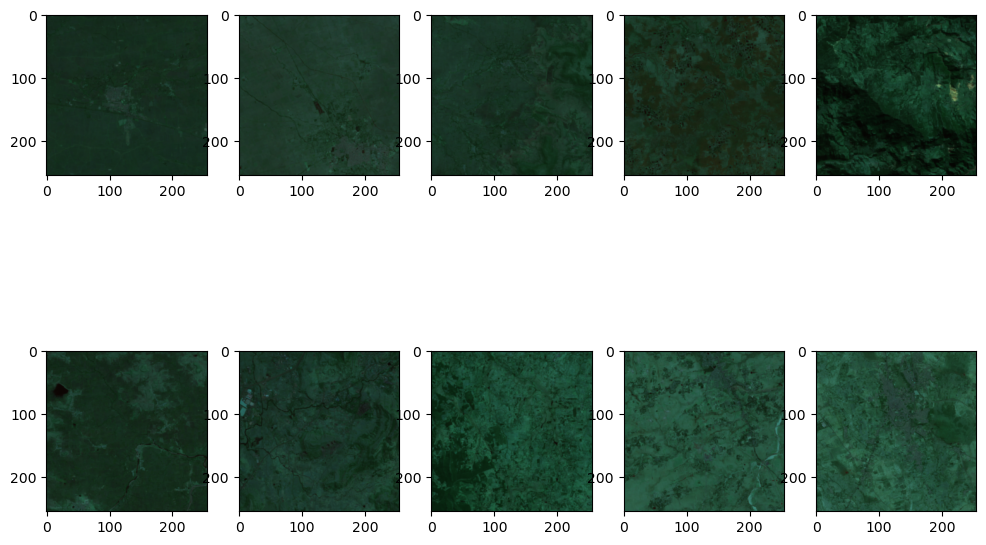

In [22]:
import os

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12,8))

axs = axs.flatten()

train_dir = os.listdir('/kaggle/input/bizinnovate-2023/dhs_train')
for i, name in enumerate(train_dir[:10]):
    ex = np.load('/kaggle/input/bizinnovate-2023/dhs_train/' + name)
    axs[i].imshow(np.moveaxis(ex['x'], 0, -1)[:, :, 2:5])

In [8]:
np.moveaxis(example['x'], 0, -1)[:, :, 2:5].transpose

array([[[0.0129 , 0.01465, 0.0138 ],
        [0.0129 , 0.0142 , 0.01275],
        [0.0138 , 0.0143 , 0.0117 ],
        ...,
        [0.0205 , 0.1008 , 0.0334 ],
        [0.0245 , 0.1104 , 0.03665],
        [0.0245 , 0.1104 , 0.03665]],

       [[0.01455, 0.0159 , 0.0138 ],
        [0.0148 , 0.0153 , 0.01305],
        [0.0125 , 0.0147 , 0.0118 ],
        ...,
        [0.0204 , 0.1105 , 0.0366 ],
        [0.02185, 0.10935, 0.03625],
        [0.02185, 0.10935, 0.03625]],

       [[0.01385, 0.01455, 0.0137 ],
        [0.0151 , 0.0148 , 0.0131 ],
        [0.0133 , 0.0135 , 0.0119 ],
        ...,
        [0.02165, 0.1119 , 0.0372 ],
        [0.0233 , 0.1079 , 0.0367 ],
        [0.0233 , 0.1079 , 0.0367 ]],

       ...,

       [[0.0161 , 0.01655, 0.0114 ],
        [0.0165 , 0.01635, 0.0113 ],
        [0.01785, 0.01525, 0.0117 ],
        ...,
        [0.02995, 0.17135, 0.0672 ],
        [0.0295 , 0.1575 , 0.0596 ],
        [0.02945, 0.14395, 0.0544 ]],

       [[0.0162 , 0.0151 , 0.011  ],
  

In [14]:
# get polar coordinate features
train['x_cart'] = 6371 * np.cos(train['lat']) * np.cos(train['lon'])
train['y_cart'] = 6371 * np.cos(train['lat']) * np.sin(train['lon'])
train['z_cart'] = 6371 * np.sin(train['lat'])
train['rot_45_x'] = (0.707 * train['lat']) + (0.707 * train['lon'])
train['rot_45_y'] = (0.707 * train['lon']) + (0.707 * train['lat'])
train['rot_30_x'] = (0.866 * train['lat']) + (0.5 * train['lon'])
train['rot_30_y'] = (0.866 * train['lon']) + (0.5 * train['lat'])

In [23]:
test['rot_45_x'] = (0.707 * test['lat']) + (0.707 * test['lon'])
test['rot_45_y'] = (0.707 * test['lon']) + (0.707 * test['lat'])
test['rot_30_x'] = (0.866 * test['lat']) + (0.5 * test['lon'])
test['rot_30_y'] = (0.866 * test['lon']) + (0.5 * test['lat'])

In [15]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,x_cart,y_cart,z_cart,rot_45_x,rot_45_y,rot_30_x,rot_30_y
year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lat,nan,1.000000,0.153961,0.003819,-0.137063,0.003819,-0.234538,-0.002257,-0.004206,0.023499,0.031098,0.109132,0.726405,0.726405,0.864071,0.560099
lon,nan,0.153961,1.000000,-0.001532,-0.265972,-0.001532,-0.324953,-0.155466,-0.154863,0.005904,-0.105971,0.152371,0.790911,0.790911,0.630401,0.904782
n_asset,nan,0.003819,-0.001532,1.000000,-0.181002,1.000000,-0.138688,-0.032996,-0.033262,-0.023407,-0.045452,-0.013571,0.001300,0.001300,0.002220,0.000362
asset_index,nan,-0.137063,-0.265972,-0.181002,1.000000,-0.181002,0.723632,0.026653,0.029448,-0.021317,-0.036725,-0.186045,-0.269885,-0.269885,-0.243180,-0.282073
n_water,nan,0.003819,-0.001532,1.000000,-0.181002,1.000000,-0.138688,-0.032996,-0.033262,-0.023407,-0.045452,-0.013571,0.001300,0.001300,0.002220,0.000362
water_index,nan,-0.234538,-0.324953,-0.138688,0.723632,-0.138688,1.000000,-0.013246,-0.010455,-0.079928,0.006469,-0.194212,-0.371277,-0.371277,-0.349807,-0.373537
cluster_id,nan,-0.002257,-0.155466,-0.032996,0.026653,-0.032996,-0.013246,1.000000,0.999942,0.203706,0.077985,-0.134963,-0.109534,-0.109534,-0.080974,-0.131319
adm1dhs,nan,-0.004206,-0.154863,-0.033262,0.029448,-0.033262,-0.010455,0.999942,1.000000,0.203425,0.077892,-0.137259,-0.110321,-0.110321,-0.082199,-0.131653
x_cart,nan,0.023499,0.005904,-0.023407,-0.021317,-0.023407,-0.079928,0.203706,0.203425,1.000000,-0.019868,-0.055372,0.018660,0.018660,0.021469,0.015078


In [19]:
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

transformer = make_column_transformer(
    (StandardScaler(), ['lat', 'lon', 'asset_index', 'cluster_id', 'rot_45_x', 'rot_45_y', 'rot_30_x', 'rot_30_y']),
    (OneHotEncoder(drop="if_binary"), ['urban', 'adm1dhs']),
    ('drop', ['DHSID_EA', 'cname', 'year', 'n_asset', 'n_water', 'path'])
)

pipe = make_pipeline(transformer, LGBMRegressor())

In [20]:
X_train = train.drop(columns=['water_index'])
y_train = train[['water_index']]

pipe.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['lat', 'lon', 'asset_index',
                                                   'cluster_id', 'rot_45_x',
                                                   'rot_45_y', 'rot_30_x',
                                                   'rot_30_y']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['urban', 'adm1dhs']),
                                                 ('drop', 'drop',
                                                  ['DHSID_EA', 'cname', 'year',
                                                   'n_asset', 'n_water',
                                                   'path'])])),
                ('lgbmr

In [21]:
from sklearn.metrics import r2_score

train_preds = pipe.predict(X_train)
r2_score(y_train, train_preds)

0.7889788384724802

In [24]:
test_preds = pipe.predict(test)
new_sub = test.copy()
new_sub['water_index'] = test_preds
new_sub = new_sub[['DHSID_EA', 'water_index']]

In [26]:
new_sub.to_csv('test.csv', index=False)

In [38]:
geotrain = (gpd.GeoDataFrame(train,
                             crs="EPSG:4326",
                             geometry=gpd.points_from_xy(train["lon"], train["lat"]))
           ).to_crs("EPSG:24378")
geotrain

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,...,urban,path,geometry,x_cart,y_cart,z_cart,rot_45_x,rot_45_y,rot_30_x,rot_30_y
0,IA-2015-7-00010004,IA,2015,9.165413,92.742696,22.0,2.650768,22.0,5.000000,10004,...,R,dhs_train/IA-2015-7-00010004.npz,POINT (5654251.347 -1396416.623),-404.361229,6144.619606,1633.947028,72.049033,72.049033,54.308596,84.897881
1,IA-2015-7-00010005,IA,2015,8.307356,93.093792,22.0,2.157784,22.0,5.000000,10005,...,R,dhs_train/IA-2015-7-00010005.npz,POINT (5718769.588 -1486732.831),-1129.723217,2551.600628,5727.364201,71.690612,71.690612,53.741067,84.772902
2,IA-2015-7-00010007,IA,2015,7.016968,93.893226,21.0,1.832751,21.0,4.619048,10007,...,R,dhs_train/IA-2015-7-00010007.npz,POINT (5849173.638 -1615250.465),4437.115909,-1642.607140,4266.554253,71.343507,71.343507,53.023307,84.820018
3,IA-2015-7-00010016,IA,2015,9.194938,92.800432,22.0,2.746096,22.0,5.000000,10016,...,R,dhs_train/IA-2015-7-00010016.npz,POINT (5660108.388 -1391406.765),-763.863164,6156.251666,1451.454268,72.110726,72.110726,54.363032,84.962643
4,IA-2015-7-00010018,IA,2015,8.055606,93.543892,22.0,2.581869,22.0,5.000000,10018,...,R,dhs_train/IA-2015-7-00010018.npz,POINT (5778309.154 -1503472.407),-972.629933,825.720187,6241.940258,71.830845,71.830845,53.748101,85.036813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18717,IA-2015-7-00360473,IA,2015,17.184983,79.989186,22.0,0.629311,22.0,4.272727,360473,...,R,dhs_train/IA-2015-7-00360473.npz,POINT (4058478.089 -725613.230),72.262189,592.181911,-6343.007154,68.702138,68.702138,54.876788,77.863127
18718,IA-2015-7-00360475,IA,2015,17.465781,78.418820,20.0,2.704372,20.0,5.000000,360475,...,U,dhs_train/IA-2015-7-00360475.npz,POINT (3883658.925 -711776.807),-1175.921638,142.980397,-6259.904625,67.790413,67.790413,54.334777,76.643589
18719,IA-2015-7-00360480,IA,2015,17.939231,79.512509,17.0,1.315361,17.0,4.882353,360480,...,R,dhs_train/IA-2015-7-00360480.npz,POINT (3997110.695 -645751.092),-2200.805889,-3230.035589,-5031.199114,68.898380,68.898380,55.291628,77.827448
18720,IA-2015-7-00360481,IA,2015,17.420175,78.491013,23.0,2.920893,23.0,5.000000,360481,...,U,dhs_train/IA-2015-7-00360481.npz,POINT (3892047.620 -716187.205),-896.885355,43.806180,-6307.401896,67.809209,67.809209,54.331377,76.683304


In [ ]:
!pip install arcgis

In [94]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode, reverse_geocode

my_gis = GIS()

for i, row in geotrain.iterrows():
    try:
        result = reverse_geocode([row['lat'], row['lon']], feature_types = "POI")
        geotrain.at[i, 'type'] = result['address']['Type']
        geotrain.at[i, 'loc_x'] = result['location']['x']
        geotrain.at[i, 'loc_y'] = result['location']['y']
    except Exception as e:
        geotrain.at[i, 'type'] = 'Unknown'
        geotrain.at[i, 'loc_x'] = np.nan
        geotrain.at[i, 'loc_y'] = np.nan

In [99]:
my_gis = GIS()

for i, row in test.iterrows():
    try:
        result = reverse_geocode([row['lat'], row['lon']], feature_types = "POI")
        test.at[i, 'type'] = result['address']['Type']
        test.at[i, 'loc_x'] = result['location']['x']
        test.at[i, 'loc_y'] = result['location']['y']
    except Exception as e:
        test.at[i, 'type'] = 'Unknown'
        test.at[i, 'loc_x'] = np.nan
        test.at[i, 'loc_y'] = np.nan

In [100]:
geotest = (gpd.GeoDataFrame(test,
                            crs="EPSG:4326",
                            geometry=gpd.points_from_xy(test["lon"], test["lat"]))
           ).to_crs("EPSG:24378")
geotest

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,cluster_id,adm1dhs,urban,path,rot_45_x,rot_45_y,rot_30_x,rot_30_y,type,loc_x,loc_y,geometry
0,IA-2015-7-00010009,IA,2015,9.220903,92.781530,22.0,2.721812,10009,1,R,dhs_valid/IA-2015-7-00010009.npz,72.115720,72.115720,54.376067,84.959257,Lake,5.684342e-14,90.000000,POINT (5657211.233 -1388905.945)
1,IA-2015-7-00010011,IA,2015,7.028410,93.883430,20.0,2.287279,10011,1,R,dhs_valid/IA-2015-7-00010011.npz,71.344671,71.344671,53.028319,84.817256,Lake,5.684342e-14,90.000000,POINT (5847688.291 -1614189.127)
2,IA-2015-7-00010017,IA,2015,12.371448,92.783665,22.0,0.677109,10017,1,R,dhs_valid/IA-2015-7-00010017.npz,74.344665,74.344665,57.105506,86.536378,Lake,5.684342e-14,90.000000,POINT (5571642.129 -1026311.408)
3,IA-2015-7-00010044,IA,2015,11.727304,92.719257,21.0,1.793683,10044,1,R,dhs_valid/IA-2015-7-00010044.npz,73.843719,73.843719,56.515474,86.158529,Lake,5.684342e-14,90.000000,POINT (5581792.571 -1101591.776)
4,IA-2015-7-00010060,IA,2015,9.185310,92.777645,22.0,2.758168,10060,1,R,dhs_valid/IA-2015-7-00010060.npz,72.087809,72.087809,54.343301,84.938096,Lake,5.684342e-14,90.000000,POINT (5657741.611 -1393148.891)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,IA-2015-7-00360403,IA,2015,17.410860,78.558810,19.0,2.823787,360403,36,U,dhs_valid/IA-2015-7-00360403.npz,67.850557,67.850557,54.357210,76.737360,Unknown,NaN,NaN,POINT (3899553.024 -716513.444)
2671,IA-2015-7-00360454,IA,2015,17.450098,78.360138,22.0,1.990244,360454,36,R,dhs_valid/IA-2015-7-00360454.npz,67.737837,67.737837,54.291854,76.584929,Unknown,NaN,NaN,POINT (3877429.569 -714185.908)
2672,IA-2015-7-00360474,IA,2015,17.973616,79.597408,20.0,2.633020,360474,36,U,dhs_valid/IA-2015-7-00360474.npz,68.982714,68.982714,55.363856,77.918164,Ocean,1.797362e+01,79.597408,POINT (4005895.874 -640852.238)
2673,IA-2015-7-00360476,IA,2015,18.956406,77.934361,21.0,0.429279,360476,36,R,dhs_valid/IA-2015-7-00360476.npz,68.501772,68.501772,55.383428,76.969360,Fjord,1.895641e+01,77.934361,POINT (3814992.859 -547809.075)


In [95]:
geotrain.to_csv('train_geodf.csv', index=False)

In [101]:
geotest.to_csv('test_geodf.csv', index=False)

In [96]:
corr = geotrain.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,x_cart,y_cart,z_cart,rot_45_x,rot_45_y,rot_30_x,rot_30_y,loc_x,loc_y
year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lat,nan,1.000000,0.153961,0.003819,-0.137063,0.003819,-0.234538,-0.002257,-0.004206,0.023499,0.031098,0.109132,0.726405,0.726405,0.864071,0.560099,0.410034,0.129782
lon,nan,0.153961,1.000000,-0.001532,-0.265972,-0.001532,-0.324953,-0.155466,-0.154863,0.005904,-0.105971,0.152371,0.790911,0.790911,0.630401,0.904782,-0.630758,0.986580
n_asset,nan,0.003819,-0.001532,1.000000,-0.181002,1.000000,-0.138688,-0.032996,-0.033262,-0.023407,-0.045452,-0.013571,0.001300,0.001300,0.002220,0.000362,0.070996,0.013486
asset_index,nan,-0.137063,-0.265972,-0.181002,1.000000,-0.181002,0.723632,0.026653,0.029448,-0.021317,-0.036725,-0.186045,-0.269885,-0.269885,-0.243180,-0.282073,-0.080219,-0.318410
n_water,nan,0.003819,-0.001532,1.000000,-0.181002,1.000000,-0.138688,-0.032996,-0.033262,-0.023407,-0.045452,-0.013571,0.001300,0.001300,0.002220,0.000362,0.070996,0.013486
water_index,nan,-0.234538,-0.324953,-0.138688,0.723632,-0.138688,1.000000,-0.013246,-0.010455,-0.079928,0.006469,-0.194212,-0.371277,-0.371277,-0.349807,-0.373537,-0.021709,-0.356800
cluster_id,nan,-0.002257,-0.155466,-0.032996,0.026653,-0.032996,-0.013246,1.000000,0.999942,0.203706,0.077985,-0.134963,-0.109534,-0.109534,-0.080974,-0.131319,0.228789,-0.126043
adm1dhs,nan,-0.004206,-0.154863,-0.033262,0.029448,-0.033262,-0.010455,0.999942,1.000000,0.203425,0.077892,-0.137259,-0.110321,-0.110321,-0.082199,-0.131653,0.226657,-0.125575
x_cart,nan,0.023499,0.005904,-0.023407,-0.021317,-0.023407,-0.079928,0.203706,0.203425,1.000000,-0.019868,-0.055372,0.018660,0.018660,0.021469,0.015078,-0.010524,-0.021189


In [97]:
geotrain

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,...,x_cart,y_cart,z_cart,rot_45_x,rot_45_y,rot_30_x,rot_30_y,type,loc_x,loc_y
0,IA-2015-7-00010004,IA,2015,9.165413,92.742696,22.0,2.650768,22.0,5.000000,10004,...,-404.361229,6144.619606,1633.947028,72.049033,72.049033,54.308596,84.897881,Lake,5.684342e-14,90.000000
1,IA-2015-7-00010005,IA,2015,8.307356,93.093792,22.0,2.157784,22.0,5.000000,10005,...,-1129.723217,2551.600628,5727.364201,71.690612,71.690612,53.741067,84.772902,Lake,5.684342e-14,90.000000
2,IA-2015-7-00010007,IA,2015,7.016968,93.893226,21.0,1.832751,21.0,4.619048,10007,...,4437.115909,-1642.607140,4266.554253,71.343507,71.343507,53.023307,84.820018,Lake,5.684342e-14,90.000000
3,IA-2015-7-00010016,IA,2015,9.194938,92.800432,22.0,2.746096,22.0,5.000000,10016,...,-763.863164,6156.251666,1451.454268,72.110726,72.110726,54.363032,84.962643,Lake,5.684342e-14,90.000000
4,IA-2015-7-00010018,IA,2015,8.055606,93.543892,22.0,2.581869,22.0,5.000000,10018,...,-972.629933,825.720187,6241.940258,71.830845,71.830845,53.748101,85.036813,Lake,5.684342e-14,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18717,IA-2015-7-00360473,IA,2015,17.184983,79.989186,22.0,0.629311,22.0,4.272727,360473,...,72.262189,592.181911,-6343.007154,68.702138,68.702138,54.876788,77.863127,Ocean,1.718498e+01,79.989186
18718,IA-2015-7-00360475,IA,2015,17.465781,78.418820,20.0,2.704372,20.0,5.000000,360475,...,-1175.921638,142.980397,-6259.904625,67.790413,67.790413,54.334777,76.643589,Unknown,NaN,NaN
18719,IA-2015-7-00360480,IA,2015,17.939231,79.512509,17.0,1.315361,17.0,4.882353,360480,...,-2200.805889,-3230.035589,-5031.199114,68.898380,68.898380,55.291628,77.827448,Fjord,1.791790e+01,79.513780
18720,IA-2015-7-00360481,IA,2015,17.420175,78.491013,23.0,2.920893,23.0,5.000000,360481,...,-896.885355,43.806180,-6307.401896,67.809209,67.809209,54.331377,76.683304,Unknown,NaN,NaN


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

transformer = make_column_transformer(
    (StandardScaler(), ['lat', 'lon', 'asset_index', 'cluster_id', 'rot_45_x', 'rot_45_y', 'rot_30_x', 'rot_30_y', 'loc_x', 'loc_y']),
    (OneHotEncoder(drop="if_binary", handle_unknown="ignore"), ['urban', 'adm1dhs', 'type']),
    ('drop', ['DHSID_EA', 'cname', 'year', 'n_asset', 'n_water', 'path'])
)

pipe = make_pipeline(transformer, LGBMRegressor(metric='r2'))

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV

param_test = {'lgbmregressor__learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'lgbmregressor__n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'lgbmregressor__num_leaves': sp_randint(6, 50), 
              'lgbmregressor__min_child_samples': sp_randint(100, 500), 
              'lgbmregressor__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'lgbmregressor__subsample': sp_uniform(loc = 0.2, scale = 0.8), 
              'lgbmregressor__max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'lgbmregressor__colsample_bytree': sp_uniform(loc = 0.4, scale = 0.6),
              'lgbmregressor__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'lgbmregressor__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

grid_search = RandomizedSearchCV(
    estimator = pipe, param_distributions = param_test, 
    n_iter = 500,
    scoring = 'r2',
    cv = 5,
    refit = True,
    random_state = 42,
    verbose = True)

grid_search.fit(X_train, y_train)
opt_parameters = grid_search.best_params_

In [ ]:
hyperopt_preds = grid_search.best_estimator_.predict(geotest)
new_sub = test.copy()
new_sub['water_index'] = hyperopt_preds
new_sub = new_sub[['DHSID_EA', 'water_index']]
new_sub

In [ ]:
new_sub.to_csv('test.csv', index=False)

In [171]:
X_train = geotrain.drop(columns=['water_index'])
y_train = geotrain[['water_index']]

pipe.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['lat', 'lon', 'asset_index',
                                                   'cluster_id', 'rot_45_x',
                                                   'rot_45_y', 'rot_30_x',
                                                   'rot_30_y', 'loc_x',
                                                   'loc_y']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['urban', 'adm1dhs', 'type']),
                                                 ('drop', 'drop',
                                                  ['DHSID_EA', 'cname', 'y

In [172]:
from sklearn.model_selection import cross_validate
cross_validate(pipe, X_train, y_train, cv=5, scoring='r2')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-pack

{'fit_time': array([0.60375881, 0.62019205, 0.60254765, 0.59119129, 0.66848016]),
 'score_time': array([0.02202058, 0.02121615, 0.02160764, 0.02181005, 0.02176261]),
 'test_score': array([0.42263656, 0.52147255, 0.45338982, 0.57420838, 0.6264758 ])}

In [173]:
from sklearn.metrics import r2_score

train_preds = pipe.predict(X_train)
r2_score(y_train, train_preds)

0.7895743583431245

In [174]:
feat_imp = pd.DataFrame({'feature': pipe[:-1].get_feature_names_out(),
                         'importance': pipe.named_steps['lgbmregressor'].feature_importances_})
feat_imp

,feature,importance
0,standardscaler__lat,441
1,standardscaler__lon,298
2,standardscaler__asset_index,637
3,standardscaler__cluster_id,236
4,standardscaler__rot_45_x,200
...,...,...
68,onehotencoder__type_Rock,0
69,onehotencoder__type_Sea,0
70,onehotencoder__type_Stream,0
71,onehotencoder__type_Unknown,0


In [175]:
test_preds = pipe.predict(geotest)
new_sub = test.copy()
new_sub['water_index'] = test_preds
new_sub = new_sub[['DHSID_EA', 'water_index']]

In [176]:
new_sub

,DHSID_EA,water_index
0,IA-2015-7-00010009,4.980784
1,IA-2015-7-00010011,5.006210
2,IA-2015-7-00010017,4.438767
3,IA-2015-7-00010044,4.793356
4,IA-2015-7-00010060,4.973267
...,...,...
2670,IA-2015-7-00360403,4.967518
2671,IA-2015-7-00360454,4.827480
2672,IA-2015-7-00360474,4.809251
2673,IA-2015-7-00360476,4.577620


In [15]:
new_sub.to_csv('test.csv', index=False)

In [ ]:
geotrain = pd.read_csv('/kaggle/input/geotrain-pca/train_geodf.csv')
geotest = pd.read_csv('/kaggle/input/geotest-pca/test_geodf.csv')

train_krig = pd.read_csv('/kaggle/input/geokrig/geotrain_krig.csv')
test_krig = pd.read_csv('/kaggle/input/geokrig/geotest_krig.csv')

In [ ]:
geotrain['kriging'] = train_krig['kriging']
geotest['kriging'] = test_krig['kriging']

geotest['z_cart'] = 6371 * np.sin(geotest['lat'])

In [28]:
corr = geotrain.corr()
corr.style.background_gradient(cmap='coolwarm')

,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,x_cart,y_cart,z_cart,rot_45_x,rot_45_y,rot_30_x,rot_30_y,loc_x,loc_y,kriging
year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lat,nan,1.000000,0.153961,0.003819,-0.137063,0.003819,-0.234538,-0.002257,-0.004206,0.023499,0.031098,0.109132,0.726405,0.726405,0.864071,0.560099,0.410034,0.129782,-0.271210
lon,nan,0.153961,1.000000,-0.001532,-0.265972,-0.001532,-0.324953,-0.155466,-0.154863,0.005904,-0.105971,0.152371,0.790911,0.790911,0.630401,0.904782,-0.630758,0.986580,-0.363041
n_asset,nan,0.003819,-0.001532,1.000000,-0.181002,1.000000,-0.138688,-0.032996,-0.033262,-0.023407,-0.045452,-0.013571,0.001300,0.001300,0.002220,0.000362,0.070996,0.013486,-0.134157
asset_index,nan,-0.137063,-0.265972,-0.181002,1.000000,-0.181002,0.723632,0.026653,0.029448,-0.021317,-0.036725,-0.186045,-0.269885,-0.269885,-0.243180,-0.282073,-0.080219,-0.318410,0.694147
n_water,nan,0.003819,-0.001532,1.000000,-0.181002,1.000000,-0.138688,-0.032996,-0.033262,-0.023407,-0.045452,-0.013571,0.001300,0.001300,0.002220,0.000362,0.070996,0.013486,-0.134157
water_index,nan,-0.234538,-0.324953,-0.138688,0.723632,-0.138688,1.000000,-0.013246,-0.010455,-0.079928,0.006469,-0.194212,-0.371277,-0.371277,-0.349807,-0.373537,-0.021709,-0.356800,0.902557
cluster_id,nan,-0.002257,-0.155466,-0.032996,0.026653,-0.032996,-0.013246,1.000000,0.999942,0.203706,0.077985,-0.134963,-0.109534,-0.109534,-0.080974,-0.131319,0.228789,-0.126043,-0.017456
adm1dhs,nan,-0.004206,-0.154863,-0.033262,0.029448,-0.033262,-0.010455,0.999942,1.000000,0.203425,0.077892,-0.137259,-0.110321,-0.110321,-0.082199,-0.131653,0.226657,-0.125575,-0.014408
x_cart,nan,0.023499,0.005904,-0.023407,-0.021317,-0.023407,-0.079928,0.203706,0.203425,1.000000,-0.019868,-0.055372,0.018660,0.018660,0.021469,0.015078,-0.010524,-0.021189,-0.084768


In [29]:
corr = geotest.corr()
corr.style.background_gradient(cmap='coolwarm')

,year,lat,lon,n_asset,asset_index,cluster_id,adm1dhs,rot_45_x,rot_45_y,rot_30_x,rot_30_y,loc_x,loc_y,kriging,z_cart
year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lat,nan,1.000000,0.130759,-0.001999,-0.122013,-0.002634,-0.004364,0.717797,0.717797,0.860497,0.545562,0.426949,0.108181,-0.346758,0.142177
lon,nan,0.130759,1.000000,-0.011316,-0.273149,-0.166553,-0.165920,0.784133,0.784133,0.617600,0.902212,-0.621059,0.986539,-0.479082,0.181574
n_asset,nan,-0.001999,-0.011316,1.000000,-0.160208,-0.022483,-0.022484,-0.009199,-0.009199,-0.007401,-0.010436,0.080450,0.006870,-0.098831,-0.025827
asset_index,nan,-0.122013,-0.273149,-0.160208,1.000000,0.048391,0.050822,-0.268203,-0.268203,-0.237156,-0.283979,-0.070058,-0.323943,0.652411,-0.177060
cluster_id,nan,-0.002634,-0.166553,-0.022483,0.048391,1.000000,0.999945,-0.118616,-0.118616,-0.087676,-0.141938,0.254933,-0.134528,-0.002513,-0.149894
adm1dhs,nan,-0.004364,-0.165920,-0.022484,0.050822,0.999945,1.000000,-0.119255,-0.119255,-0.088723,-0.142156,0.253131,-0.133999,0.001098,-0.151828
rot_45_x,nan,0.717797,0.784133,-0.009199,-0.268203,-0.118616,-0.119255,1.000000,1.000000,0.972372,0.975111,-0.177917,0.771289,-0.553510,0.216514
rot_45_y,nan,0.717797,0.784133,-0.009199,-0.268203,-0.118616,-0.119255,1.000000,1.000000,0.972372,0.975111,-0.177917,0.771289,-0.553510,0.216514
rot_30_x,nan,0.860497,0.617600,-0.007401,-0.237156,-0.087676,-0.088723,0.972372,0.972372,1.000000,0.896415,0.011983,0.603445,-0.521269,0.206095


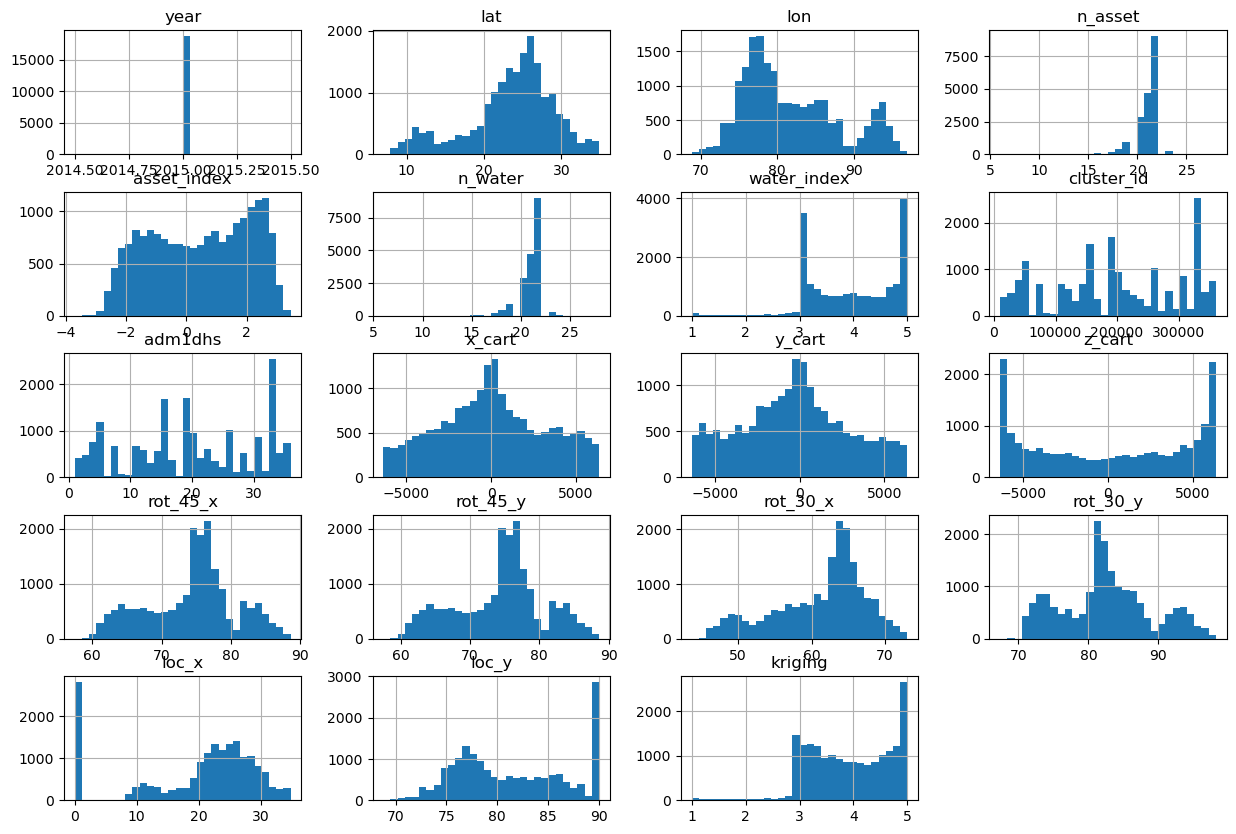

In [30]:
geotrain.hist(bins=30, figsize=(15, 10))
plt.show()

In [31]:
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE

transformer = make_column_transformer(
    (QuantileTransformer(n_quantiles=4), ['lat', 'lon', 'z_cart', 'kriging', 'asset_index', 'rot_45_x', 'rot_45_y', 'rot_30_x', 'rot_30_y']),
    (OneHotEncoder(drop="if_binary"), ['urban']),
    ('drop', ['DHSID_EA', 'cname', 'year', 'n_asset', 'n_water', 'cluster_id', 'adm1dhs', 'path', 'loc_x', 'loc_y', 'x_cart', 'y_cart', 'type'])
)

rfe = RFE(Ridge(), n_features_to_select=30)

pipe = make_pipeline(transformer, rfe, LGBMRegressor())

In [32]:
X_train = geotrain.drop(columns=['water_index'])
y_train = geotrain[['water_index']]

pipe.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('quantiletransformer',
                                                  QuantileTransformer(n_quantiles=4),
                                                  ['lat', 'lon', 'z_cart',
                                                   'kriging', 'asset_index',
                                                   'rot_45_x', 'rot_45_y',
                                                   'rot_30_x', 'rot_30_y']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['urban']),
                                                 ('drop', 'drop',
                                                  ['DHSID_EA', 'cname', 'year',
                                                   'n_asset', 'n_water',
                                                   'cluster_id', 'ad

In [33]:
from sklearn.model_selection import cross_validate
cross_validate(pipe, X_train, y_train, cv=5, scoring='r2')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'fit_time': array([0.69511628, 0.76940656, 0.70479536, 0.71227288, 0.70551229]),
 'score_time': array([0.01881766, 0.01789761, 0.01960635, 0.01780415, 0.01818562]),
 'test_score': array([0.71052604, 0.81094432, 0.79447434, 0.8257286 , 0.83103352])}

In [34]:
feat_imp = pd.DataFrame({'feature': pipe[-2].get_feature_names_out(pipe[0].get_feature_names_out()),
                         'importance': pipe.named_steps['lgbmregressor'].feature_importances_})
feat_imp

,feature,importance
0,quantiletransformer__lat,314
1,quantiletransformer__lon,356
2,quantiletransformer__z_cart,259
3,quantiletransformer__kriging,774
4,quantiletransformer__asset_index,604
5,quantiletransformer__rot_45_x,194
6,quantiletransformer__rot_45_y,0
7,quantiletransformer__rot_30_x,242
8,quantiletransformer__rot_30_y,226
9,onehotencoder__urban_U,31


In [35]:
from sklearn.metrics import r2_score

train_preds = pipe.predict(X_train)
r2_score(y_train, train_preds)

0.9091654064956527

In [14]:
test_preds = pipe.predict(geotest)
new_sub = test.copy()
new_sub['water_index'] = test_preds
new_sub = new_sub[['DHSID_EA', 'water_index']]

In [15]:
new_sub.to_csv('test.csv', index=False)

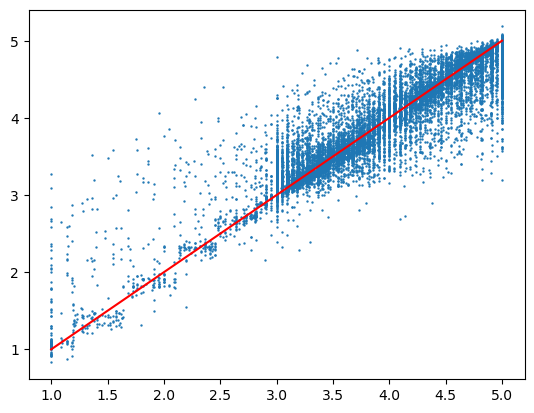

In [17]:
plt.scatter(y_train, train_preds, s=0.5)
plt.plot(np.arange(1,6), np.arange(1,6), c='r');

In [13]:
test_preds = pipe.predict(geotest)

In [36]:
idw_test = pd.read_csv('/kaggle/input/pca-idw-test/test.csv')
idw_test['orig_preds'] = test_preds
idw_test

,DHSID_EA,water_index,orig_preds
0,IA-2015-7-00010009,5.000000,4.970148
1,IA-2015-7-00010011,4.834646,4.880654
2,IA-2015-7-00010017,4.192098,4.438557
3,IA-2015-7-00010044,4.980362,4.832848
4,IA-2015-7-00010060,5.000000,4.977867
...,...,...,...
2670,IA-2015-7-00360403,4.917135,4.931684
2671,IA-2015-7-00360454,5.000000,4.906161
2672,IA-2015-7-00360474,4.806549,4.684100
2673,IA-2015-7-00360476,4.840247,4.401299


In [37]:
idw_test['new_preds'] = ((idw_test['water_index'] * 0.3) + idw_test['orig_preds']) / 1.3
idw_test

,DHSID_EA,water_index,orig_preds,new_preds
0,IA-2015-7-00010009,5.000000,4.970148,4.977037
1,IA-2015-7-00010011,4.834646,4.880654,4.870037
2,IA-2015-7-00010017,4.192098,4.438557,4.381682
3,IA-2015-7-00010044,4.980362,4.832848,4.866890
4,IA-2015-7-00010060,5.000000,4.977867,4.982974
...,...,...,...,...
2670,IA-2015-7-00360403,4.917135,4.931684,4.928326
2671,IA-2015-7-00360454,5.000000,4.906161,4.927816
2672,IA-2015-7-00360474,4.806549,4.684100,4.712358
2673,IA-2015-7-00360476,4.840247,4.401299,4.502595


In [190]:
new_sub = idw_test[['DHSID_EA', 'new_preds']]
new_sub = new_sub.rename(columns={'new_preds': 'water_index'})
new_sub

,DHSID_EA,water_index
0,IA-2015-7-00010009,4.949357
1,IA-2015-7-00010011,4.796053
2,IA-2015-7-00010017,4.535661
3,IA-2015-7-00010044,4.950971
4,IA-2015-7-00010060,4.953956
...,...,...
2670,IA-2015-7-00360403,4.936478
2671,IA-2015-7-00360454,4.856156
2672,IA-2015-7-00360474,4.841790
2673,IA-2015-7-00360476,4.543731


In [191]:
new_sub.to_csv('test.csv', index=False)

In [82]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV

pipe_ridge = make_pipeline(
    transformer, rfe, RidgeCV()
)

pipe_dt = make_pipeline(transformer, rfe, DecisionTreeRegressor(random_state=123))

pipe_rf = make_pipeline(
    transformer, rfe, RandomForestRegressor(random_state=123)
)
pipe_xgb = make_pipeline(
    transformer,
    rfe,
    XGBRegressor(
        random_state=123, verbosity=0
    ),
)
pipe_lgbm = make_pipeline(
    transformer, rfe, LGBMRegressor(random_state=123)
)

regressors = {
    "ridge": pipe_ridge,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm
}

In [83]:
from sklearn.ensemble import StackingRegressor

stacking_model = StackingRegressor(list(regressors.items()))
stacking_model.fit(X_train, y_train);

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.

In [84]:
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_.flatten(),
    index=classifiers.keys(),
    columns=["Coefficient"],
).sort_values("Coefficient", ascending=False)

,Coefficient
logistic regression,0.466983
random forest,0.394927
LightGBM,0.174239
decision tree,0.004390
XGBoost,-0.024895


In [85]:
from sklearn.metrics import r2_score

train_preds = stacking_model.predict(X_train)
r2_score(y_train, train_preds)

0.8676709126475277

In [86]:
test_preds = pipe.predict(geotest)
new_sub = test.copy()
new_sub['water_index'] = test_preds
new_sub = new_sub[['DHSID_EA', 'water_index']]

In [87]:
new_sub.to_csv('test.csv', index=False)